### *Forex* markets are exchanges to trade in different currencies

Hedging is a way to minimize or eliminate foreugn exchange risk

Two common hedges: 

-forward contracts: lock in an exchange rate (ER) today at which the currency transaction will occur at a future date. forexample, I lock to buy the USD for 70 CAD, when it becomes 100, I benefit 30! (risk: it can go other way)

-options: Set an exchange rate at which the ocmpany may choose to exchange currencies, if the current ER is more favorable, then the company will not exercise this option. wee need to pay premoum that is the insuarnce to pay risk

In [2]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# FOREX currency data for model input

In [3]:
forex_data = pd.read_csv("ForexMarket.csv", header=None)
forex_data.head()

,0,1,2,3,4,5
0,2017.01.02,2:00,116.858,116.870,116.858,116.870
1,2017.01.02,2:01,116.875,116.915,116.875,116.901
2,2017.01.02,2:02,116.901,116.901,116.901,116.901
3,2017.01.02,2:03,116.901,116.906,116.897,116.900
4,2017.01.02,2:04,116.900,116.903,116.900,116.903


In [4]:
forex_data.columns = ['Date','Time','Open','High','Low','Close']

In [5]:
forex_data.head()

,Date,Time,Open,High,Low,Close
0,2017.01.02,2:00,116.858,116.870,116.858,116.870
1,2017.01.02,2:01,116.875,116.915,116.875,116.901
2,2017.01.02,2:02,116.901,116.901,116.901,116.901
3,2017.01.02,2:03,116.901,116.906,116.897,116.900
4,2017.01.02,2:04,116.900,116.903,116.900,116.903


In [6]:
forex_data["Hour"] = forex_data["Time"].apply(lambda t: t.split(":")[0])
forex_data["Hour"] = forex_data["Hour"].astype(int)
forex_data.head()

,Date,Time,Open,High,Low,Close,Hour
0,2017.01.02,2:00,116.858,116.870,116.858,116.870,2
1,2017.01.02,2:01,116.875,116.915,116.875,116.901,2
2,2017.01.02,2:02,116.901,116.901,116.901,116.901,2
3,2017.01.02,2:03,116.901,116.906,116.897,116.900,2
4,2017.01.02,2:04,116.900,116.903,116.900,116.903,2


#### Take the mean of closing price for every hour

In [7]:
forex_agg = forex_data.groupby(["Date","Hour"])["Close"].mean()
forex_agg = forex_agg.reset_index().sort_values(by=["Date","Hour"],ascending=True)

In [8]:
forex_agg.head()

,Date,Hour,Close
0,2017.01.02,2,116.997768
1,2017.01.02,3,117.325172
2,2017.01.02,4,117.401138
3,2017.01.02,5,117.403000
4,2017.01.02,6,117.356714


In [9]:
len(forex_agg)

525

In [10]:
forex_agg.columns

Index(['Date', 'Hour', 'Close'], dtype='object')

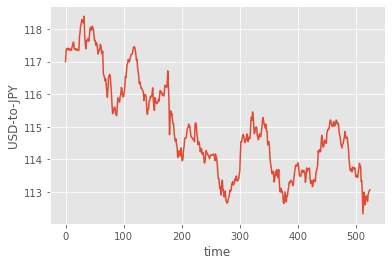

In [11]:
plt.xlabel('time')
plt.ylabel('USD-to-JPY')
plt.plot(forex_agg['Close'])

There is a downtrend

### Moving Average and RSI based Features

In [12]:
for i in range(1,7):
    forex_agg['close_lag' + str(i)] = forex_agg['Close'].shift(i)

In [13]:
#talib doesnt work

# import talib

# for n in [6,12,18,24]:

#     # Create the moving average and divide by the close price to average it out
#     forex_agg['ma_' + str(n)] = talib.SMA(forex_agg['Close'].values,
#                               timeperiod=n) / forex_agg['Close']
#     # Create the RSI indicator
#     forex_agg['rsi_' + str(n)] = talib.RSI(forex_agg['Close'].values, timeperiod=n)
# forex_agg.head(10)

Formula for RS = average gain over n periods/average loss over n periods

RSI = 100 - (100/(1 + RS)) RSI: Relative Strenght indicator

In [14]:
def rsiFunc(prices, n):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100 - 100/(1+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100 - 100/(1+rs)

    return rsi

In [15]:
for n in [6,12,18,24]:
    # Create the moving average and divide by the close price to average it out
    #SMA simple moving average
    forex_agg['ma_' + str(n)] = forex_agg['Close'].rolling(window=n).mean() / forex_agg['Close']  #divuide by close for normalization
    forex_agg['rsi_' + str(n)]=rsiFunc(forex_agg['Close'], n)

In [16]:
forex_agg.head(20)

,Date,Hour,Close,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_6,rsi_6,ma_12,rsi_12,ma_18,rsi_18,ma_24,rsi_24
0,2017.01.02,2,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.108055,NaN,83.979669,NaN,66.416980,NaN,75.20552
1,2017.01.02,3,117.325172,116.997768,NaN,NaN,NaN,NaN,NaN,NaN,83.108055,NaN,83.979669,NaN,66.416980,NaN,75.20552
2,2017.01.02,4,117.401138,117.325172,116.997768,NaN,NaN,NaN,NaN,NaN,83.108055,NaN,83.979669,NaN,66.416980,NaN,75.20552
3,2017.01.02,5,117.403000,117.401138,117.325172,116.997768,NaN,NaN,NaN,NaN,83.108055,NaN,83.979669,NaN,66.416980,NaN,75.20552
4,2017.01.02,6,117.356714,117.403000,117.401138,117.325172,116.997768,NaN,NaN,NaN,83.108055,NaN,83.979669,NaN,66.416980,NaN,75.20552
5,2017.01.02,7,117.408610,117.356714,117.403000,117.401138,117.325172,116.997768,NaN,0.999206,83.108055,NaN,83.979669,NaN,66.416980,NaN,75.20552
6,2017.01.02,8,117.391678,117.408610,117.356714,117.403000,117.401138,117.325172,116.997768,0.999909,80.147390,NaN,83.979669,NaN,66.416980,NaN,75.20552
7,2017.01.02,9,117.361983,117.391678,117.408610,117.356714,117.403000,117.401138,117.325172,1.000215,74.557738,NaN,83.979669,NaN,66.416980,NaN,75.20552
8,2017.01.02,10,117.384917,117.361983,117.391678,117.408610,117.356714,117.403000,117.401138,0.999996,76.102356,NaN,83.979669,NaN,66.416980,NaN,75.20552
9,2017.01.02,11,117.339186,117.384917,117.361983,117.391678,117.408610,117.356714,117.403000,1.000295,66.449141,NaN,83.979669,NaN,66.416980,NaN,75.20552


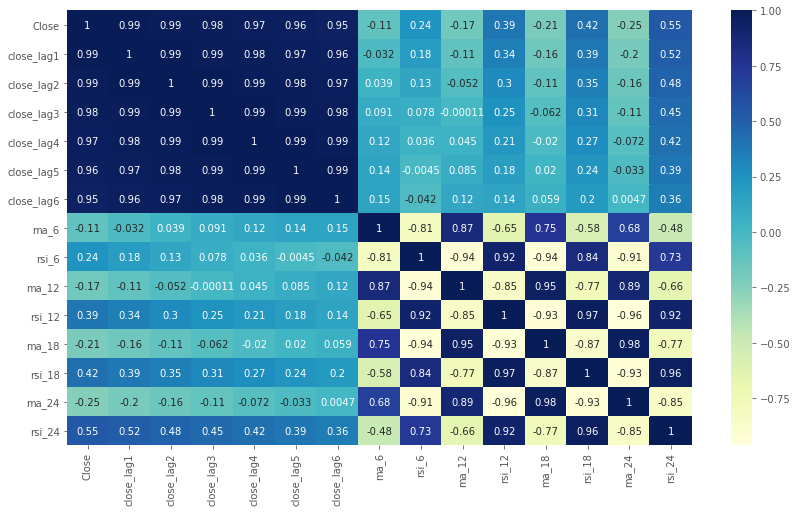

In [17]:
plt.figure(figsize=(14,8))
corr = forex_agg.drop(columns=["Date","Hour"]).corr()
sns.heatmap(data=corr, annot=True, cmap="YlGnBu")

### Data Cleaning and Outlier Detection

#### Check for null or na on columns

In [18]:
forex_agg.isna().sum()

Date           0
Hour           0
Close          0
close_lag1     1
close_lag2     2
close_lag3     3
close_lag4     4
close_lag5     5
close_lag6     6
ma_6           5
rsi_6          0
ma_12         11
rsi_12         0
ma_18         17
rsi_18         0
ma_24         23
rsi_24         0
dtype: int64

In [19]:
forex_agg.fillna(forex_agg.mean(),inplace=True)

In [20]:
forex_agg.isna().sum()

Date          0
Hour          0
Close         0
close_lag1    0
close_lag2    0
close_lag3    0
close_lag4    0
close_lag5    0
close_lag6    0
ma_6          0
rsi_6         0
ma_12         0
rsi_12        0
ma_18         0
rsi_18        0
ma_24         0
rsi_24        0
dtype: int64

In [21]:
# Computing IQR Inter Quarter Range
Q1 = forex_agg[["Close"]].quantile(0.25)
Q3 = forex_agg[["Close"]].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Close    2.2943
dtype: float64


c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


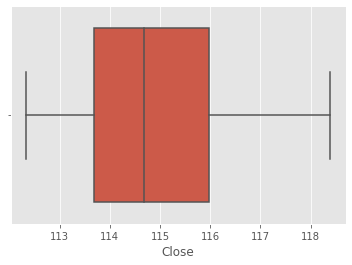

In [22]:
sns.boxplot("Close", data=forex_agg)
# plt.xscale("log")

In [23]:
len(forex_agg[forex_agg.Close > Q3['Close'] + 1.5*IQR[0]]) * 100/len(forex_agg)

0.0

In [24]:
len(forex_agg[forex_agg.Close < Q1['Close'] - 1.5*IQR[0]]) * 100/len(forex_agg)

0.0

There are no outliers

# Prepare The Data For Modelling

Dropping **time** columns as they do not have significance as a driver for closing price.

In [25]:
forex_final = forex_agg.drop(columns = ["Date","Hour"], axis = 1)

In [26]:
forex_final.head()

,Close,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_6,rsi_6,ma_12,rsi_12,ma_18,rsi_18,ma_24,rsi_24
0,116.997768,114.959874,114.963539,114.967309,114.971227,114.975556,114.979731,1.000184,83.108055,1.00042,83.979669,1.00067,66.41698,1.000896,75.20552
1,117.325172,116.997768,114.963539,114.967309,114.971227,114.975556,114.979731,1.000184,83.108055,1.00042,83.979669,1.00067,66.41698,1.000896,75.20552
2,117.401138,117.325172,116.997768,114.967309,114.971227,114.975556,114.979731,1.000184,83.108055,1.00042,83.979669,1.00067,66.41698,1.000896,75.20552
3,117.403000,117.401138,117.325172,116.997768,114.971227,114.975556,114.979731,1.000184,83.108055,1.00042,83.979669,1.00067,66.41698,1.000896,75.20552
4,117.356714,117.403000,117.401138,117.325172,116.997768,114.975556,114.979731,1.000184,83.108055,1.00042,83.979669,1.00067,66.41698,1.000896,75.20552


## Normalize the data

In [27]:
forex_n = forex_final.loc[:, forex_final.columns != 'Close']

In [28]:
forex_n = (forex_n - forex_n.mean()) / forex_n.std()

In [29]:
forex_m = pd.concat([forex_n,forex_final.loc[:,'Close']],axis=1)

In [30]:
forex_m.head()

,close_lag1,close_lag2,close_lag3,close_lag4,close_lag5,close_lag6,ma_6,rsi_6,ma_12,rsi_12,ma_18,rsi_18,ma_24,rsi_24,Close
0,0.000000,0.000000,-9.621360e-15,0.000000,-9.660532e-15,-9.680626e-15,0.0,1.521782,1.483158e-13,2.029095,1.176394e-13,1.342949,-1.475083e-13,2.062248,116.997768
1,1.375201,0.000000,-9.621360e-15,0.000000,-9.660532e-15,-9.680626e-15,0.0,1.521782,1.483158e-13,2.029095,1.176394e-13,1.342949,-1.475083e-13,2.062248,117.325172
2,1.596138,1.374929,-9.621360e-15,0.000000,-9.660532e-15,-9.680626e-15,0.0,1.521782,1.483158e-13,2.029095,1.176394e-13,1.342949,-1.475083e-13,2.062248,117.401138
3,1.647400,1.596220,1.374708e+00,0.000000,-9.660532e-15,-9.680626e-15,0.0,1.521782,1.483158e-13,2.029095,1.176394e-13,1.342949,-1.475083e-13,2.062248,117.403000
4,1.648657,1.647565,1.596375e+00,1.374567,-9.660532e-15,-9.680626e-15,0.0,1.521782,1.483158e-13,2.029095,1.176394e-13,1.342949,-1.475083e-13,2.062248,117.356714


In [31]:
X = forex_m.loc[:, forex_m.columns != 'Close']
Y = forex_m['Close']

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=42, test_size=0.2)

In [33]:
print("Length Of training data ", len(X_train))
print("Length Of test data ", len(X_test))
print("Length Of training Y ", len(Y_train))
print("Length Of test data Y", len(Y_test))

Length Of training data  420
Length Of test data  105
Length Of training Y  420
Length Of test data Y 105


# Linear regression model

In [34]:
def linear_reg(y_train, X_train, isSummary=False):

    # Add a bias column to the training dataset before fitting the model
    X_train = sm.tools.tools.add_constant(X_train, has_constant='add')
    lm_1 = OLS(y_train,X_train).fit()
    
    if isSummary:
        #Visualise the results of the model
        print(lm_1.summary())
    return lm_1

In [35]:
mod = linear_reg(Y_train, X_train, isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.193e+04
Date:                Fri, 30 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:53:46   Log-Likelihood:                 506.51
No. Observations:                 420   AIC:                            -983.0
Df Residuals:                     405   BIC:                            -922.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9534      0.004   3.18e+04      0.0

# 2.6 The Testing significance of metrics by using p-value and VIF

In [36]:
def vif_cal(input_df):
    """
    Calculates VIF for the dependent variables

    """
    vif_df = pd.DataFrame(columns = [ 'Var', 'Vif']);
    i=0
    for var in input_df:
        y_vars = input_df[var]
        x_vars = input_df.drop(var, inplace=False, axis=1)
        r2s = OLS(y_vars, x_vars).fit().rsquared
        vif = round(1/(1-r2s),2)
        vif_df.loc[i] = [var,vif]
        i+=1
    return vif_df.sort_values(by = 'Vif', ascending = False, inplace = False)

In [37]:
vif_cal(X_train)

,Var,Vif
2,close_lag3,196.84
1,close_lag2,167.25
4,close_lag5,152.92
3,close_lag4,151.38
11,rsi_18,114.69
0,close_lag1,108.12
10,ma_18,96.27
9,rsi_12,93.64
5,close_lag6,88.22
12,ma_24,66.46


# 2.7 Hyperparameter tuning and final model selection

In [38]:
X_t_1 = X_train.drop(columns=["close_lag3"],axis=1)

In [39]:
linear_reg(Y_train,X_t_1,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.106e+04
Date:                Fri, 30 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:53:46   Log-Likelihood:                 474.52
No. Observations:                 420   AIC:                            -921.0
Df Residuals:                     406   BIC:                            -864.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9536      0.004   2.95e+04      0.0

In [40]:
vif_cal(X_t_1)

,Var,Vif
3,close_lag5,150.71
10,rsi_18,114.61
0,close_lag1,108.03
1,close_lag2,106.64
2,close_lag4,103.96
9,ma_18,96.25
8,rsi_12,93.64
4,close_lag6,87.97
11,ma_24,66.44
12,rsi_24,58.36


In [41]:
X_t_2 = X_t_1.drop(columns=["close_lag1","close_lag2","close_lag4","close_lag5"],axis=1)

In [42]:
linear_reg(Y_train,X_t_2,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1776.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          4.00e-322
Time:                        12:53:46   Log-Likelihood:                 15.931
No. Observations:                 420   AIC:                            -11.86
Df Residuals:                     410   BIC:                             28.54
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9579      0.012   9967.604      0.0

In [43]:
vif_cal(X_t_2)

,Var,Vif
6,rsi_18,105.82
5,ma_18,92.78
4,rsi_12,90.99
7,ma_24,65.82
8,rsi_24,55.03
2,rsi_6,40.00
3,ma_12,33.98
1,ma_6,6.29
0,close_lag6,1.74


In [44]:
X_t_3 = X_t_2.drop(columns=["rsi_24"],axis=1)

In [45]:
linear_reg(Y_train,X_t_3,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1849.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          7.71e-317
Time:                        12:53:46   Log-Likelihood:               -0.42852
No. Observations:                 420   AIC:                             18.86
Df Residuals:                     411   BIC:                             55.22
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9571      0.012   9599.119      0.0

In [46]:
vif_cal(X_t_3)

,Var,Vif
5,ma_18,90.40
4,rsi_12,80.38
7,ma_24,52.50
6,rsi_18,45.52
3,ma_12,33.96
2,rsi_6,32.77
1,ma_6,6.12
0,close_lag6,1.32


In [47]:
X_t_4 = X_t_3.drop(columns=["ma_18"],axis=1)

In [48]:
linear_reg(Y_train,X_t_4,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2089.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          2.65e-317
Time:                        12:53:46   Log-Likelihood:                -3.2820
No. Observations:                 420   AIC:                             22.56
Df Residuals:                     412   BIC:                             54.89
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9571      0.012   9545.722      0.0

In [49]:
vif_cal(X_t_4)

,Var,Vif
4,rsi_12,80.37
5,rsi_18,44.68
2,rsi_6,32.50
3,ma_12,16.39
6,ma_24,11.80
1,ma_6,5.59
0,close_lag6,1.32


In [50]:
X_t_5 = X_t_4.drop(columns=["rsi_12"],axis=1)

In [51]:
linear_reg(Y_train,X_t_5,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     2256.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          4.33e-312
Time:                        12:53:46   Log-Likelihood:                -19.502
No. Observations:                 420   AIC:                             53.00
Df Residuals:                     413   BIC:                             81.29
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9543      0.012   9202.362      0.0

In [52]:
vif_cal(X_t_5)

,Var,Vif
3,ma_12,16.01
5,ma_24,11.54
2,rsi_6,10.91
4,rsi_18,8.14
1,ma_6,5.31
0,close_lag6,1.31


In [53]:
X_t_6 = X_t_5.drop(columns=["rsi_6"],axis=1)

In [54]:
linear_reg(Y_train,X_t_6,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2507.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          6.53e-307
Time:                        12:53:46   Log-Likelihood:                -35.665
No. Observations:                 420   AIC:                             83.33
Df Residuals:                     414   BIC:                             107.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9524      0.013   8868.741      0.0

In [55]:
vif_cal(X_t_6)

,Var,Vif
2,ma_12,13.03
4,ma_24,11.54
3,rsi_18,6.51
1,ma_6,5.13
0,close_lag6,1.30


In [56]:
X_t_7 = X_t_6.drop(columns=["ma_6"],axis=1)

In [57]:
linear_reg(Y_train,X_t_7,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     3134.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          1.74e-308
Time:                        12:53:46   Log-Likelihood:                -36.132
No. Observations:                 420   AIC:                             82.26
Df Residuals:                     415   BIC:                             102.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9525      0.013   8869.685      0.0

In [58]:
vif_cal(X_t_7)

,Var,Vif
3,ma_24,10.36
2,rsi_18,6.49
1,ma_12,4.99
0,close_lag6,1.30


In [59]:
X_t_8 = X_t_7.drop(columns=["rsi_18"],axis=1)

In [60]:
model = linear_reg(Y_train,X_t_8,isSummary=True)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     3682.
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          4.38e-299
Time:                        12:53:47   Log-Likelihood:                -62.284
No. Observations:                 420   AIC:                             132.6
Df Residuals:                     416   BIC:                             148.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9511      0.014   8345.047      0.0

In [61]:
vif_cal(X_t_8)

,Var,Vif
1,ma_12,4.99
2,ma_24,4.96
0,close_lag6,1.06


# Regression Diagnosis

There is a set of auusmptions that need to be verified:

## Outliers

 Data points that are far away from the fitted regression line are
called outliers, and these can impact the accuracy of the model.
Plotting normalized residual vs. leverage will give us a good
understanding of the outliers points. Residual is the difference
between actual vs. predicted, and leverage is a measure of how far
away the independent variable values of an observation are from
those of the other observations

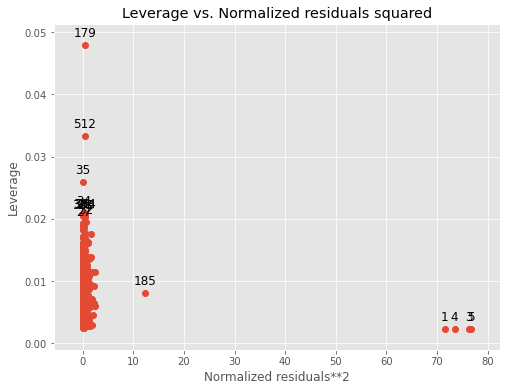

In [64]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(model, ax = ax)

From the chart we see that observations that have high leverage and
residual. Running a Bonferroni outlier test will give us p-values for each observation, and
those observations with p value < 0.05 are the outliers affecting the accuracy. It is a good
practice to consult or apply business domain knowledge to make a decision on removing
the outlier points and re-running the model, as these points could be natural in the
process although they are mathematically found as outliers.

In [74]:
# Find outliers #
# Bonferroni outlier test
test = model.outlier_test()

# print('Bad data points (bonf(p) < 0.05):')
# print(test[test.icol(2) < 0.05])
print(test[test['unadj_p']<0.05])

     student_resid       unadj_p       bonf(p)
5         9.641370  5.532987e-20  2.323855e-17
3         9.614451  6.853851e-20  2.878617e-17
185       3.564941  4.062868e-04  1.706405e-01
4         9.393910  3.904568e-19  1.639919e-16
1         9.245168  1.244463e-18  5.226745e-16


# Performance On Test Data

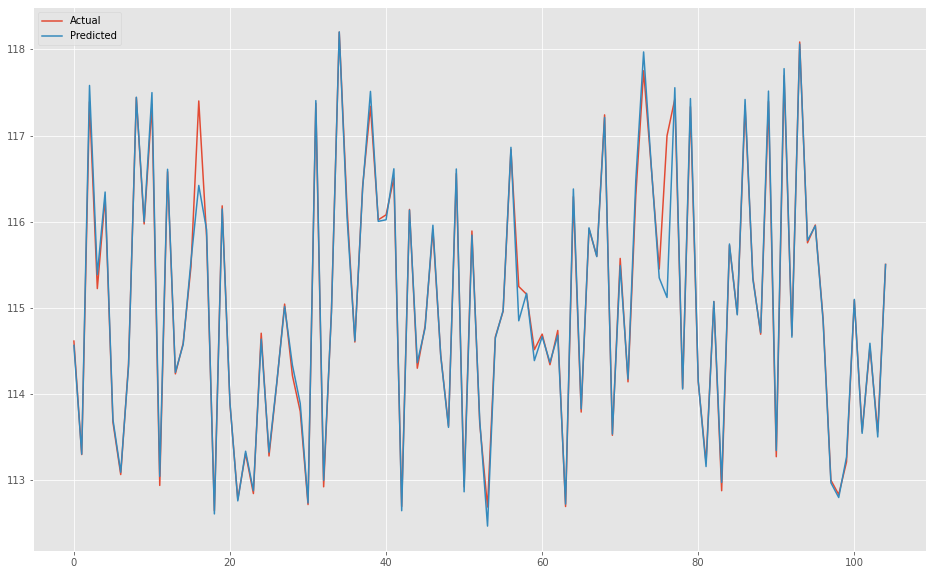

In [75]:
X_test = sm.tools.tools.add_constant(X_test, has_constant='add')
Y_test_p = mod.predict(X_test)

plt.figure(figsize=(16,10))
plt.plot(range(0,len(Y_test)),Y_test, label='Actual')
plt.plot(range(0,len(Y_test)),Y_test_p, label='Predicted')
plt.legend(loc='upper left')

## RSquared on the test data

In [76]:
r2_score(Y_test, Y_test_p)

0.9787607443920345

## Residuals and Assumption Validation

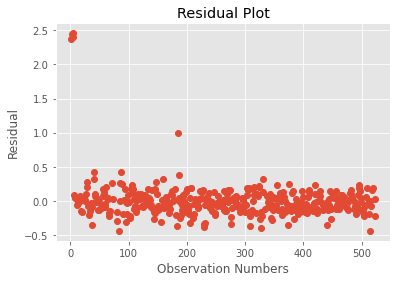

In [88]:
plt.plot(model.resid,'o')
plt.title('Residual Plot')
plt.ylabel('Residual')
plt.xlabel('Observation Numbers')
plt.show()


In [77]:
error = Y_test - Y_test_p

#### White Noise Residuals

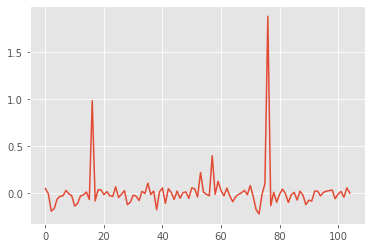

In [78]:
plt.plot(range(0,len(Y_test)),error)

Residuals are white noise with no real distribution.

#### No autocorrelation

c:\users\rahel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


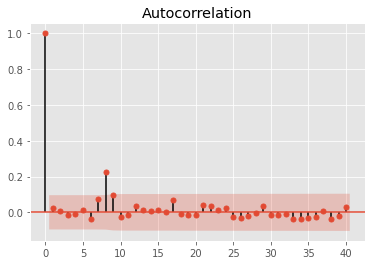

In [79]:
acf = smt.graphics.plot_acf(model.resid, lags=40 , alpha=0.05)
acf.show()

only one lag out of the significant area

**The Durbin-Watson test gives a value of ~2 which means there is no autocorrelation.**

There shows that there is no autocorrelation between the residuals, neither is their any particular distribution which means there is no variance escaping out of the model.

#### Heteroskedasticity Test

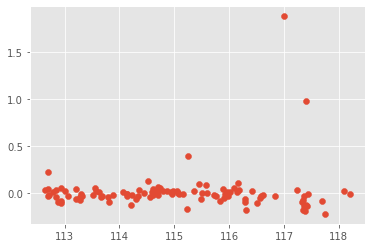

In [80]:
plt.scatter(Y_test,error)

No funnel or cone shaped pattern so no heteroskedasticity in the residuals.
verify the asumption of linear regression